In [29]:
import os

import zarr

zarr_path = '/mnt/nvme0n1/datasets/physicsnemo_dev/domino/stl_data_zarr_full/train'
# zarr_path = '/mnt/nvme0n1/datasets/lustre/train'

def extract_key_data(zarr_path, required_keys):

    stores = [s for s in os.listdir(zarr_path) if s.endswith('.zarr')]
    stores = sorted(stores)

    data = {}
    for key in required_keys:
        data[key] = []
    data['valid_stores'] = []

    for store_name in stores:
        try:
            store_path = os.path.join(zarr_path, store_name)
            store = zarr.open(store_path, mode='r')
            
            # Check if all required keys are accessible before appending anything
            required_keys = ['stl_areas', 'stl_coordinates', 'stl_centers']
            all_keys_valid = True
            
            for key in required_keys:
                if key not in store:
                    print(f"Missing key '{key}' in store: {store_name}")
                    all_keys_valid = False
                    break
            
            # Only append data if all keys are valid
            if all_keys_valid:
                for key in required_keys:
                    data[key].append(store[key])
                data['valid_stores'].append(store_name)
            else:
                print(f"Skipping store {store_name} due to missing keys")
                
        except Exception as e:
            print("Error in store_name: ", store_name)
            print(e)

    print(f"Successfully loaded {len(data['valid_stores'])} stores")
    return data

extracted_data = extract_key_data(zarr_path, ['stl_areas', 'stl_coordinates', 'stl_centers'])

print(len(extracted_data['valid_stores']))

Successfully loaded 431 stores
431


In [30]:
import cupy as cp
import numpy as np


def compute_shape_descriptor(
        areas_zarr,
        # x_bound, y_bound, z_bound,
        coords_zarr,
        centers_zarr
    ):
    """
    Compute a 10D statistical shape descriptor vector using CuPy.
    
    Parameters:
        areas_zarr: Zarr array of triangle areas
        x_bound, y_bound, z_bound: [min, max] bounds for each axis
        coords_zarr: Zarr array of shape (N, 3) with all surface point coordinates
        centers_zarr: Zarr array of shape (M, 3) with triangle center coordinates
    
    Returns:
        descriptor (np.ndarray): shape (10,)
    """

    # 1–3: Bounding box dimensions
    # x_extent = x_bound[1] - x_bound[0]
    # y_extent = y_bound[1] - y_bound[0]
    # z_extent = z_bound[1] - z_bound[0]

    # 4–5: Surface area stats
    areas_cp = cp.asarray(areas_zarr)
    surface_area_sum = float(cp.sum(areas_cp).get())
    surface_area_std = float(cp.std(areas_cp).get())

    # 6–7: Triangle center spread
    centers_cp = cp.asarray(centers_zarr)
    mesh_centroid = cp.mean(centers_cp, axis=0)
    dists = cp.linalg.norm(centers_cp - mesh_centroid, axis=1)
    centroid_dist_mean = float(cp.mean(dists).get())
    centroid_dist_std = float(cp.std(dists).get())

    # 8–10: PCA eigenvalues of point cloud
    coords_cp = cp.asarray(coords_zarr)
    centered = coords_cp - cp.mean(coords_cp, axis=0)
    cov = cp.cov(centered.T)
    eigvals = cp.linalg.eigvalsh(cov)  # Already sorted ascending
    eigvals = cp.flip(eigvals)  # Flip to descending
    eigvals_norm = eigvals / cp.sum(eigvals)

    pca_eigvals = eigvals_norm.get()  # Convert to NumPy

    # Final descriptor vector
    descriptor = np.array([
        # x_extent, y_extent, z_extent,
        surface_area_sum, surface_area_std,
        centroid_dist_mean, centroid_dist_std,
        pca_eigvals[0], pca_eigvals[1], pca_eigvals[2],
    ], dtype=np.float32)

    return descriptor

descriptors = []
for i in range(len(extracted_data['valid_stores'])):
    descriptor = compute_shape_descriptor(
        extracted_data['stl_areas'][i],
        # x_bounds[i],
        # y_bounds[i],
        # z_bounds[i],
        extracted_data['stl_coordinates'][i],
        extracted_data['stl_centers'][i]
    )
    descriptors.append(descriptor)

descriptors = cp.asarray(descriptors)
print(descriptors)


[[3.6097374e+01 2.8707649e-04 1.5252813e+00 ... 7.7352083e-01
  1.8071510e-01 4.5764048e-02]
 [3.5052971e+01 2.8263417e-04 1.4604008e+00 ... 7.7940166e-01
  1.7634773e-01 4.4250581e-02]
 [3.3425705e+01 2.7389926e-04 1.4670367e+00 ... 7.7981204e-01
  1.8355861e-01 3.6629342e-02]
 ...
 [3.5744312e+01 3.1379619e-04 1.5249125e+00 ... 7.7467507e-01
  1.8786715e-01 3.7457798e-02]
 [3.4360790e+01 2.5824161e-04 1.4449270e+00 ... 7.7887905e-01
  1.6909927e-01 5.2021682e-02]
 [3.5967285e+01 2.9488865e-04 1.4406322e+00 ... 7.1803617e-01
  2.3510562e-01 4.6858184e-02]]


In [33]:
import cupy as cp
from cuml.manifold import UMAP


def run_umap_gpu(descriptor_matrix_np, n_neighbors=20, min_dist=0.1):
    descriptors_cp = cp.asarray(descriptor_matrix_np.astype(np.float32))

    umap_model = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
    )    
    embedding_cp = umap_model.fit_transform(descriptors_cp)

    embedding_np = cp.asnumpy(embedding_cp)
    return embedding_np

embedding_np = run_umap_gpu(descriptors)

[2025-07-29 23:50:11.773] [CUML] [info] build_algo set to brute_force_knn because random_state is given


/tmp/ipykernel_138/3377585430.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embedding[:, 0], embedding[:, 1],


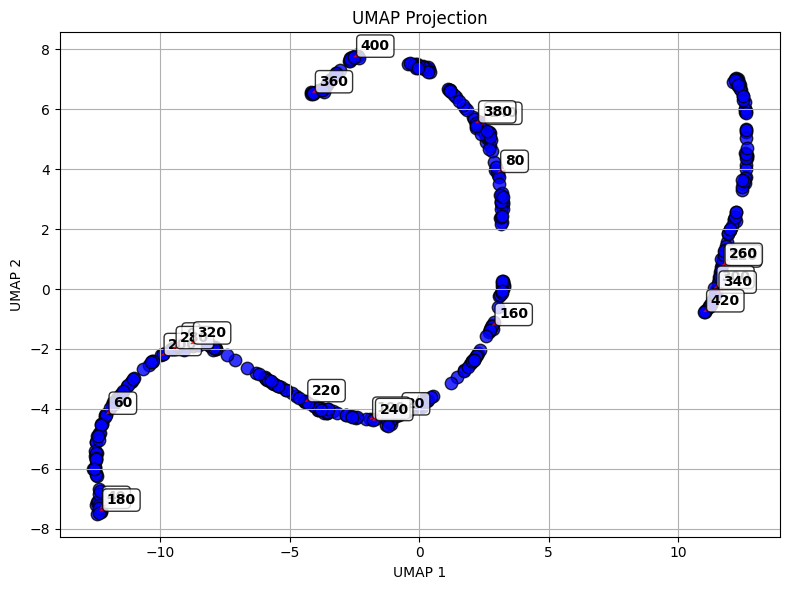

In [34]:
import matplotlib.pyplot as plt


def plot_umap_embedding(embedding, labels=None, title="UMAP Projection"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                          c=labels if labels is not None else 'blue',
                          cmap='tab10', s=80, edgecolor='k', alpha=0.8)
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Labels")

    # Add text annotations every 20 points
    for i in range(0, len(embedding), 20):
        x, y = embedding[i]
        plt.annotate(f'{i}', (x, y), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', alpha=0.7))

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_umap_embedding(embedding_np)